In [1]:
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_score, mutual_info_score, adjusted_mutual_info_score, completeness_score, v_measure_score, rand_score
from sklearn.mixture import GaussianMixture as SklearnGMM
from scipy.stats import entropy
from scipy.optimize import linear_sum_assignment

In [ ]:
from utils.metrics import ClusteringMetrics
from utils.gmm import GaussianMixture

In [2]:
def plot_gmm(gmm, X, labels_pred, initial_means=None, initial_covariances=None, ax=None, title='Gaussian Mixture'):
    if ax is None:
        ax = plt.gca()
    
    cmap = ListedColormap(plt.cm.winter(np.linspace(0, 1, gmm.n_components)))    
    
    for i, color in zip(range(gmm.n_components), cmap.colors):
        mask = labels_pred == i
        ax.scatter(X[mask, 0], X[mask, 1], c=[color], s=1, zorder=1)

    # Plot ellipses and means
    for n, color in zip(range(gmm.n_components), cmap.colors):
        mean = gmm.means_[n].detach().cpu().numpy()
        
        # Determine covariance based on type
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[n].detach().cpu().numpy()
        elif gmm.covariance_type == 'tied':
            cov = gmm.covariances_.detach().cpu().numpy()
        elif gmm.covariance_type == 'diagonal':
            cov = np.diag(gmm.covariances_[n].detach().cpu().numpy())
        elif gmm.covariance_type == 'spherical':
            cov = np.eye(gmm.n_features) * gmm.covariances_[n].detach().cpu().numpy()

        # Calculate ellipse parameters
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        # Plot ellipses for standard deviations
        for std_dev, alpha in zip([1, 2, 3], [0.6, 0.3, 0.1]):
            width, height = 2 * np.sqrt(vals) * std_dev
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor='black', facecolor=color, alpha=alpha, zorder=0)
            ax.add_patch(ellipse)

        # Plot mean as a dot
        ax.plot(mean[0], mean[1], 'ko', markersize=3, zorder=4)

    if initial_means is not None:
        for n in range(gmm.n_components):
            initial_mean = initial_means[n].detach().cpu().numpy()
            ax.plot(initial_mean[0], initial_mean[1], 'rx', markersize=10, zorder=4)
            if initial_covariances is not None:
                initial_cov = initial_covariances[n].detach().cpu().numpy()
                vals, vecs = np.linalg.eigh(initial_cov)
                order = vals.argsort()[::-1]
                vals, vecs = vals[order], vecs[:, order]
                theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

                width, height = 2 * np.sqrt(vals)
                ellipse = Ellipse(xy=initial_mean, width=width, height=height, angle=theta, edgecolor='red', linestyle='--', facecolor='none', zorder=4)
                ax.add_patch(ellipse)

    ax.set_title(title)
    ax.axis('equal')

tensor([[-3.9644,  0.7930],
        [ 3.9293,  1.0496],
        [-1.0204, -0.2415],
        [ 1.0846,  0.2630]])
tensor([[-3.7377,  0.6331],
        [ 4.3744,  3.5750],
        [-0.3173, -0.0762],
        [ 2.8898,  0.0907]])
tensor([[-3.8559,  0.7106],
        [ 4.3079,  3.2897],
        [-0.2272, -0.0501],
        [ 3.1856, -0.1124]])
tensor([[-4.0543,  0.9797],
        [ 4.0193,  2.0638],
        [-0.0314, -0.0049],
        [ 3.9487, -2.0080]])


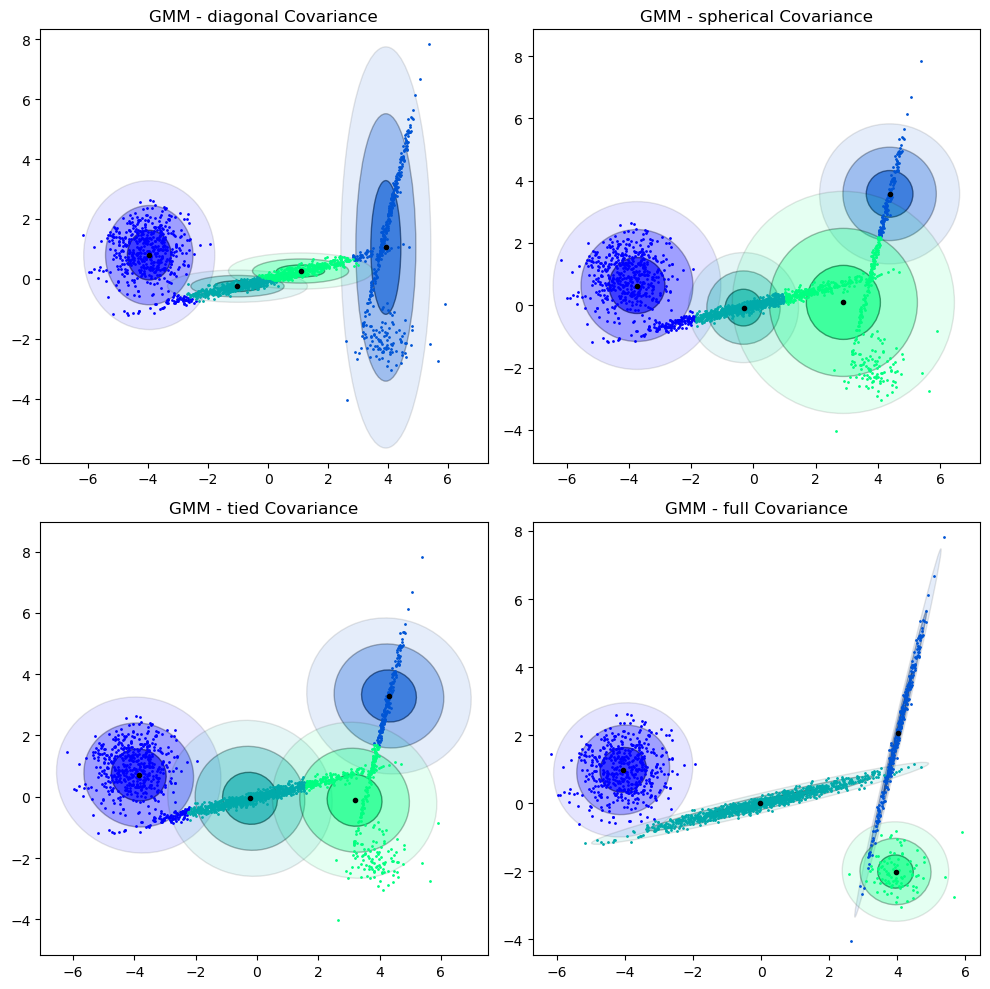

In [3]:
device = 'cpu'

init_params = 'random'
n_features = 2
n_components = 4
random_state = 3
n_init = 1
max_iter = 1000
np.random.seed(random_state)

n_samples_1 = 1000
n_samples_2 = 500
n_samples_3 = 100
n_samples_4 = 300
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
C_2 = np.array([[0.0, 0.2], [0.4, 1.7]])
component_1 = np.dot(np.random.randn(n_samples_1, 2), C)
component_2 = 0.7 * np.random.randn(n_samples_2, 2) + np.array([-4, 1])
component_3 = .5 * np.random.randn(n_samples_3, 2) + np.array([4, -2])
component_4 = np.dot(np.random.randn(n_samples_4, 2), C_2)+ np.array([4, 2])

X = np.concatenate([component_1, component_2, component_3, component_4])

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.cat([torch.zeros(n_samples_1), torch.ones(n_samples_2), 2 * torch.ones(n_samples_3), 3 * torch.ones(n_samples_4)]).long()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
covariance_types = ['diagonal', 'spherical', 'tied', 'full']

for ax, cov_type in zip(axs.ravel(), covariance_types):
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type=cov_type, max_iter=max_iter, n_init=n_init, init_params=init_params, random_state=random_state, device=device)
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X_tensor, y_pred, ax=ax, title=f'GMM - {cov_type} Covariance', initial_means=None, initial_covariances=None)
    # print means
    print(gmm.means_)

plt.tight_layout()
plt.show()

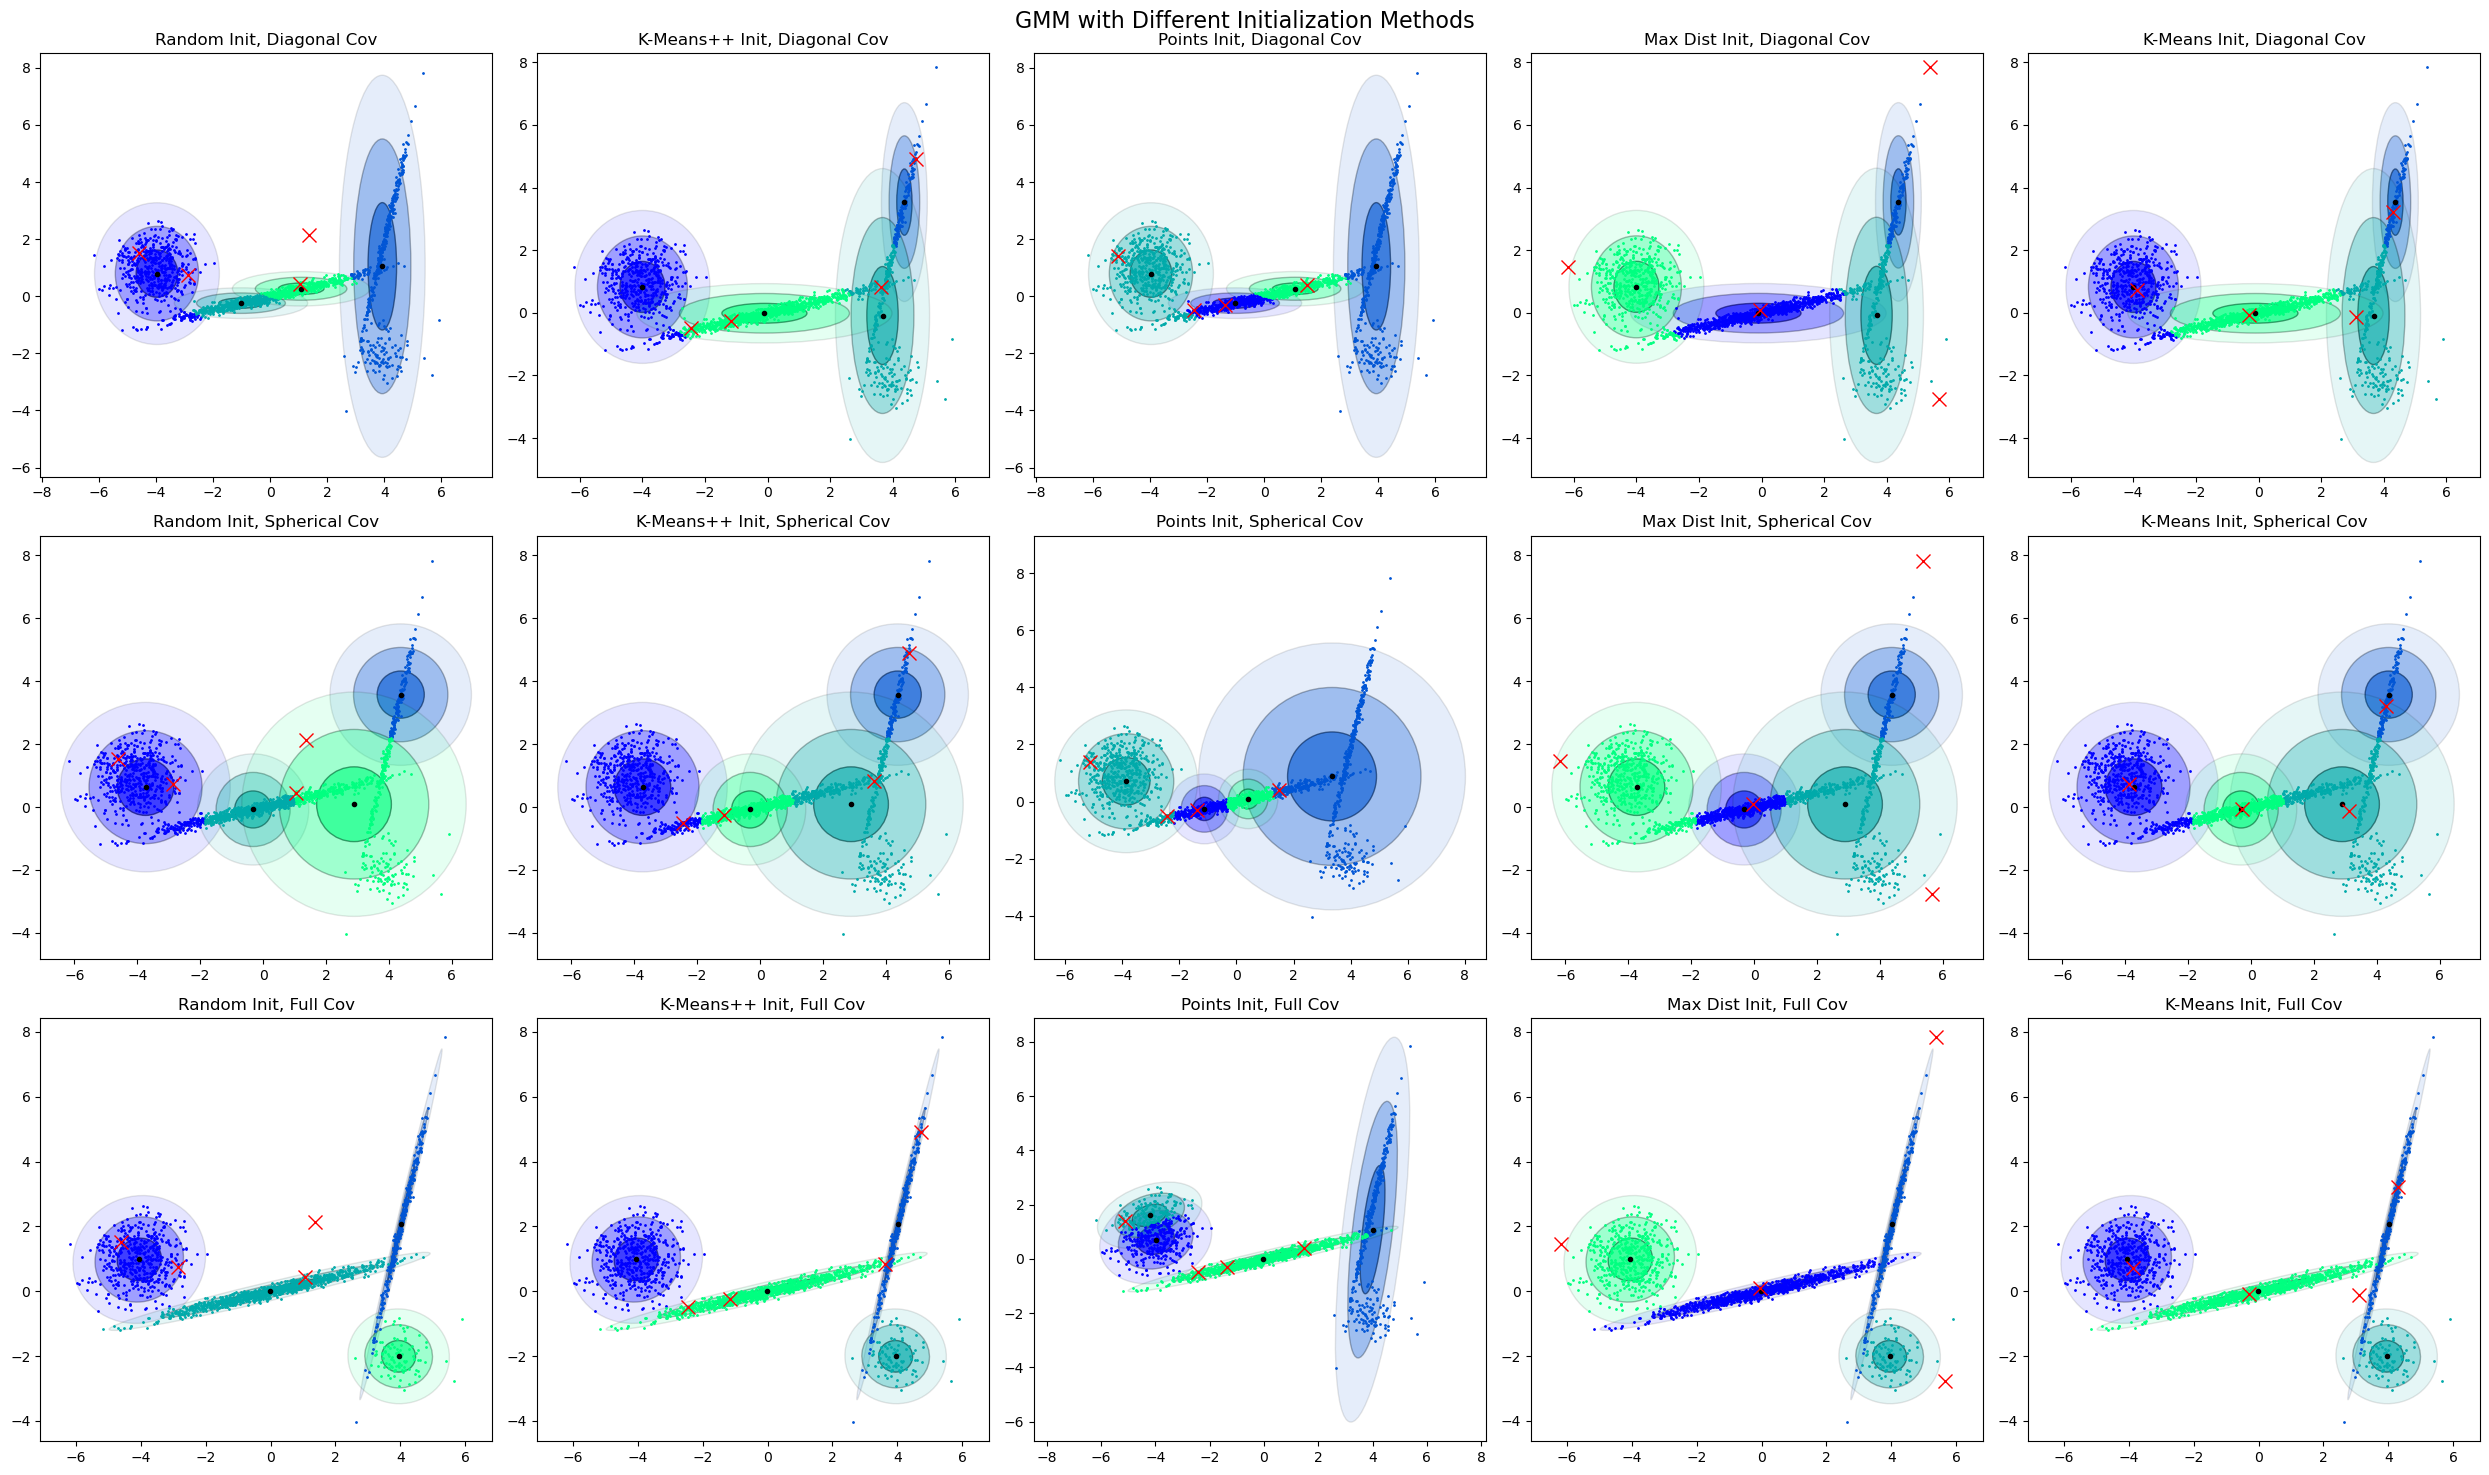

In [4]:
# Prepare the 3 by 5 plot for five initialization methods
fig, axs = plt.subplots(3, 5, figsize=(25, 15))
init_methods = ['random', 'kpp', 'points', 'maxdist', 'kmeans']
titles = ['Random Init', 'K-Means++ Init', 'Points Init', 'Max Dist Init', 'K-Means Init']

for ax, init_method, title in zip(axs[0,:], init_methods, titles):
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='diagonal', 
                          max_iter=max_iter, n_init=n_init, init_params=init_method, random_state=random_state, device=device)
    if init_method == 'points':
        gmm.means_init = gmm._init_kpoints(X_tensor, n_components)
    elif init_method == 'kpp':
        gmm.means_init = gmm._init_kpp(X_tensor, n_components)
    elif init_method == 'random':
        gmm.means_init = gmm._init_krandom(X_tensor, n_components)
    elif init_method == 'maxdist':
        gmm.means_init = gmm._init_maxdist(X_tensor, n_components)
    elif init_method == 'kmeans':
        gmm.means_init = gmm._init_kmeans(X_tensor, n_components)
    initial_mean = gmm.means_init
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, ax=ax, title=f'{title}, Diagonal Cov')

# Repeat for spherical covariance type
titles = ['Random Init', 'K-Means++ Init', 'Points Init', 'Max Dist Init', 'K-Means Init']
for ax, init_method, title in zip(axs[1,:], init_methods, titles):
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='spherical', 
                          max_iter=max_iter, n_init=n_init, init_params=init_method, random_state=random_state, device=device)
    if init_method == 'points':
        gmm.means_init = gmm._init_kpoints(X_tensor, n_components)
    elif init_method == 'kpp':
        gmm.means_init = gmm._init_kpp(X_tensor, n_components)
    elif init_method == 'random':
        gmm.means_init = gmm._init_krandom(X_tensor, n_components)
    elif init_method == 'maxdist':
        gmm.means_init = gmm._init_maxdist(X_tensor, n_components)
    elif init_method == 'kmeans':
        gmm.means_init = gmm._init_kmeans(X_tensor, n_components)
    initial_mean = gmm.means_init
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, initial_covariances=None, ax=ax, title=f'{title}, Spherical Cov')

# Repeat for full covariance type
titles = ['Random Init', 'K-Means++ Init', 'Points Init', 'Max Dist Init', 'K-Means Init']
for ax, init_method, title in zip(axs[2,:], init_methods, titles):
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='full', 
                          max_iter=max_iter, n_init=n_init, init_params=init_method, random_state=random_state, device=device)
    if init_method == 'points':
        gmm.means_init = gmm._init_kpoints(X_tensor, n_components)
    elif init_method == 'kpp':
        gmm.means_init = gmm._init_kpp(X_tensor, n_components)
    elif init_method == 'random':
        gmm.means_init = gmm._init_krandom(X_tensor, n_components)
    elif init_method == 'maxdist':
        gmm.means_init = gmm._init_maxdist(X_tensor, n_components)
    elif init_method == 'kmeans':
        gmm.means_init = gmm._init_kmeans(X_tensor, n_components)
    initial_mean = gmm.means_init
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, initial_covariances=None, ax=ax, title=f'{title}, Full Cov')

plt.suptitle('GMM with Different Initialization Methods', fontsize=16)
plt.tight_layout()
plt.show()

## Unsupervised clustering metrics

In [5]:
# Extend component range comparison to include AIC
components_range = np.arange(2, 11)

silhouette = np.zeros(components_range.shape)
davies_bouldin = np.zeros(components_range.shape)
calinski_harabasz = np.zeros(components_range.shape)
bic = np.zeros(components_range.shape)
aic = np.zeros(components_range.shape)

for i, n in tqdm(enumerate(components_range), total=len(components_range)):
    gmm = GaussianMixture(n_features=n_features, n_components=n, covariance_type='full',
                          max_iter=max_iter, n_init=n_init, init_params='kpp', random_state=random_state, device=device)
    gmm.fit(X_tensor)
    silhouette[i] = ClusteringMetrics.silhouette_score(X_tensor, gmm.predict(X_tensor), n_components=gmm.n_components)
    davies_bouldin[i] = ClusteringMetrics.davies_bouldin_index(X_tensor, gmm.predict(X_tensor), n_components=gmm.n_components)
    calinski_harabasz[i] = ClusteringMetrics.calinski_harabasz_score(X_tensor, gmm.predict(X_tensor), n_components=gmm.n_components)
    bic[i] = ClusteringMetrics.bic_score(gmm.lower_bound_, X_tensor, gmm.n_components, gmm.covariance_type)
    aic[i] = ClusteringMetrics.aic_score(gmm.lower_bound_, X_tensor, gmm.n_components, gmm.covariance_type)

100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


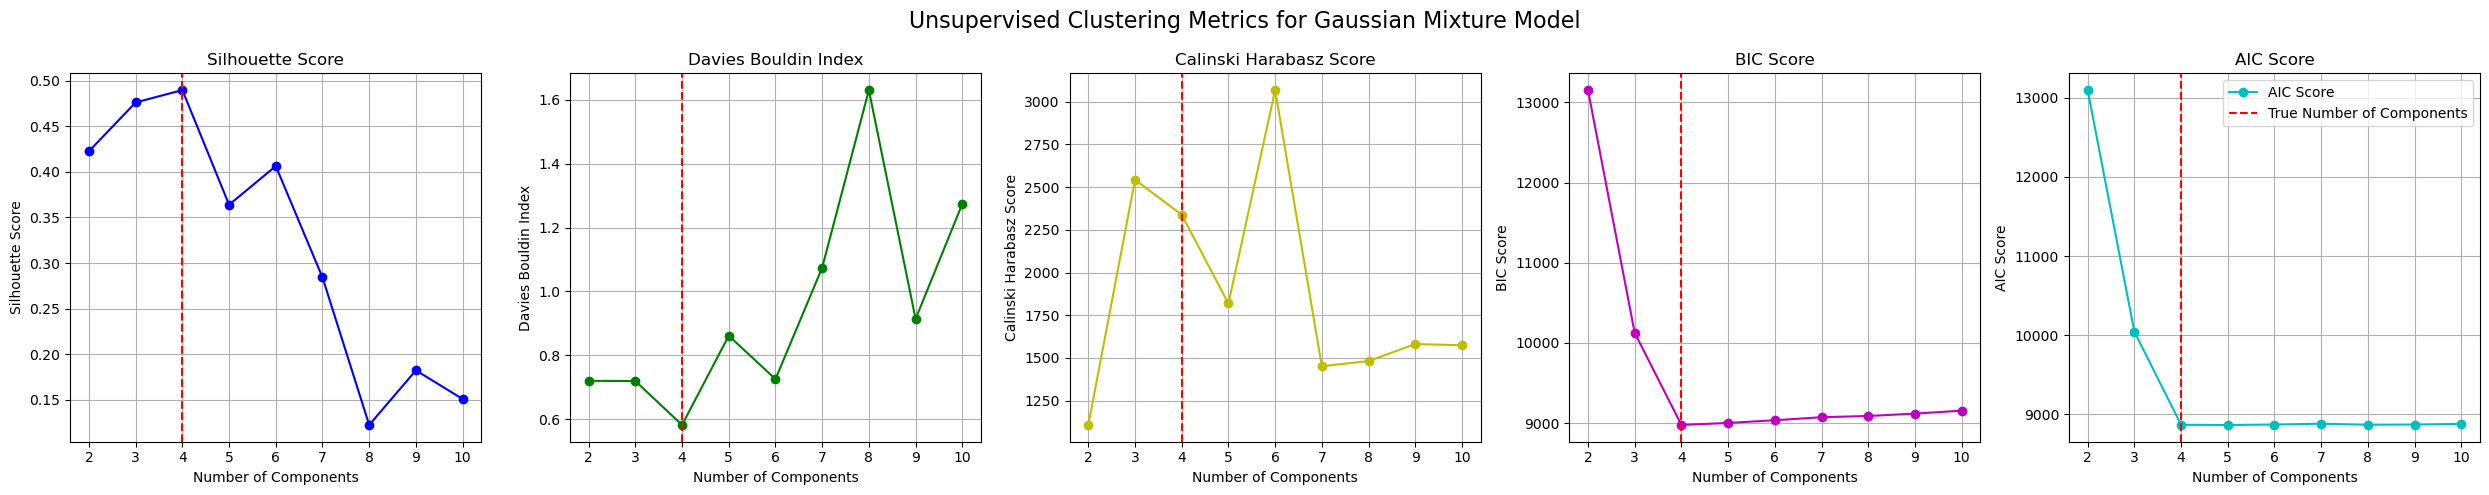

Ideal number of components based on Silhouette Score: 4
Ideal number of components based on Davies Bouldin Index: 4
Ideal number of components based on Calinski Harabasz Score: 6
Ideal number of components based on BIC: 4
Ideal number of components based on AIC: 5
True number of components: 4


In [6]:
# Create 1 by 5 plot
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax[0].plot(components_range, silhouette, marker='o', color='b', label='Silhouette Score')
ax[0].set_title('Silhouette Score')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Silhouette Score')
ax[0].grid(True)
ax[0].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')
ax[1].plot(components_range, davies_bouldin, marker='o', color='g', label='Davies Bouldin Index')
ax[1].set_title('Davies Bouldin Index')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Davies Bouldin Index')
ax[1].grid(True)
ax[1].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')
ax[2].plot(components_range, calinski_harabasz, marker='o', color='y', label='Calinski Harabasz Score')
ax[2].set_title('Calinski Harabasz Score')
ax[2].set_xlabel('Number of Components')
ax[2].set_ylabel('Calinski Harabasz Score')
ax[2].grid(True)
ax[2].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')
ax[3].plot(components_range, bic, marker='o', color='m', label='BIC Score')
ax[3].set_title('BIC Score')
ax[3].set_xlabel('Number of Components')
ax[3].set_ylabel('BIC Score')
ax[3].grid(True)
ax[3].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')
ax[4].plot(components_range, aic, marker='o', color='c', label='AIC Score')
ax[4].set_title('AIC Score')
ax[4].set_xlabel('Number of Components')
ax[4].set_ylabel('AIC Score')
ax[4].grid(True)
ax[4].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')
plt.suptitle('Unsupervised Clustering Metrics for Gaussian Mixture Model', fontsize=16)
plt.tight_layout()
plt.legend()
plt.show()

# print ideal number of components
print(f'Ideal number of components based on Silhouette Score: {components_range[np.argmax(silhouette)]}')
print(f'Ideal number of components based on Davies Bouldin Index: {components_range[np.argmin(davies_bouldin)]}')
print(f'Ideal number of components based on Calinski Harabasz Score: {components_range[np.argmax(calinski_harabasz)]}')
print(f'Ideal number of components based on BIC: {components_range[np.argmin(bic)]}')
print(f'Ideal number of components based on AIC: {components_range[np.argmin(aic)]}')
print(f'True number of components: {n_components}')


## Supervised Clustering metrics

In [7]:
def match_labels(y_true, y_pred):
    # Create the contingency table
    contingency_matrix = torch.zeros((y_true.max() + 1, y_pred.max() + 1), dtype=torch.int32)
    for i in range(y_true.size(0)):
        contingency_matrix[y_true[i], y_pred[i]] += 1
    
    # Apply the Hungarian algorithm to find the best match between true and predicted labels
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix.cpu().numpy())
    
    # Create a mapping from predicted to true labels
    label_mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    # Apply the mapping to y_pred
    matched_labels = torch.tensor([label_mapping[label.item()] for label in y_pred], dtype=torch.int64)
    return matched_labels

def plot_clustering(X, y_true, y_pred, means, covariances, ax, scores=None):
    y_pred = match_labels(y_true, y_pred)

    correct = y_true == y_pred
    incorrect = y_true != y_pred

    ax.scatter(X[correct][:, 0].cpu(), X[correct][:, 1].cpu(), c='lightblue', label='Correct prediction', s=5)
    ax.scatter(X[incorrect][:, 0].cpu(), X[incorrect][:, 1].cpu(), c='red', label='Incorrect prediction', s=5)

    for i in range(means.shape[0]):
        mean = means[i].cpu().numpy()
        cov = covariances[i].cpu().numpy()

        if i == 0:
            ax.scatter(mean[0], mean[1], c='black', marker='x', label=f'Mean')
        else:
            ax.scatter(mean[0], mean[1], c='black', marker='x')
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(5.991 * eigvals)
        if i == 0:
            ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linestyle='--', label=f'95% CI')
        else:
            ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linestyle='--')
        ax.add_patch(ell)

    ax.legend()
    ax.set_title('Clustering Results')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    # Display scores on the plot
    if scores is not None:
        score_text = '\n'.join([f"{metric}: {score:.2f}" for metric, score in scores.items()])
        ax.text(1.02, 0.5, score_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=1))

In [8]:
# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='full',
                      max_iter=max_iter, n_init=n_init, init_params='kpp', random_state=random_state, device=device)
gmm.fit(X_tensor)
y_pred = gmm.predict(X_tensor)

all_scores = gmm.evaluate_clustering(X_tensor, true_labels=y_tensor)

# Compare with sklearn metrics
sklearn_scores = {
    "rand_score": rand_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "adjusted_rand_score": adjusted_rand_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "mutual_info_score": mutual_info_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "normalized_mutual_info_score": normalized_mutual_info_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "adjusted_mutual_info_score": adjusted_mutual_info_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "fowlkes_mallows_score": fowlkes_mallows_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "homogeneity_score": homogeneity_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "completeness_score": completeness_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "v_measure_score": v_measure_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "silhouette_score": silhouette_score(X_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "davies_bouldin_index": davies_bouldin_score(X_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "calinski_harabasz_score": calinski_harabasz_score(X_tensor.cpu().numpy(), y_pred.cpu().numpy())
}

print("Comparison with sklearn metrics:\n")
for metric, value in sklearn_scores.items():
    print(f"{metric}: {value:.5f}, torch: {all_scores[metric]:.5f}, difference: {abs(value - all_scores[metric]):.5}")

# Compare BIC and AIC scores
sklearn_gmm = SklearnGMM(n_components=n_components, covariance_type='full', max_iter=max_iter, n_init=n_init,
                         init_params='kmeans', random_state=random_state)
sklearn_gmm.fit(X_tensor.cpu().numpy())
sklearn_bic = sklearn_gmm.bic(X_tensor.cpu().numpy())
torch_bic = ClusteringMetrics.bic_score(gmm.lower_bound_, X_tensor, n_components, gmm.covariance_type)
sklearn_aic = sklearn_gmm.aic(X_tensor.cpu().numpy())
torch_aic = ClusteringMetrics.aic_score(gmm.lower_bound_, X_tensor, n_components, gmm.covariance_type)

print(f"Torch BIC: {torch_bic}, Sklearn BIC: {sklearn_bic}, difference: {abs(torch_bic - sklearn_bic)}")
print(f"Torch AIC: {torch_aic}, Sklearn AIC: {sklearn_aic}, difference: {abs(torch_aic - sklearn_aic)}")

Comparison with sklearn metrics:

rand_score: 0.99161, torch: 0.99161, difference: 3.8965e-09
adjusted_rand_score: 0.98206, torch: 0.98206, difference: 4.1545e-09
mutual_info_score: 1.09647, torch: 1.09647, difference: 4.1533e-08
normalized_mutual_info_score: 0.96465, torch: 0.96465, difference: 7.7191e-08
adjusted_mutual_info_score: 0.96458, torch: 0.96463, difference: 5.3344e-05
fowlkes_mallows_score: 0.98874, torch: 0.98874, difference: 2.0157e-08
homogeneity_score: 0.96559, torch: 0.96565, difference: 6.6317e-05
completeness_score: 0.96372, torch: 0.96365, difference: 7.0055e-05
v_measure_score: 0.96465, torch: 0.96465, difference: 2.0058e-06
silhouette_score: 0.48960, torch: 0.48960, difference: 0.0
davies_bouldin_index: 0.58217, torch: 0.58217, difference: 1.1202e-08
calinski_harabasz_score: 2338.06221, torch: 2338.06323, difference: 0.0010204
Torch BIC: 8976.634765625, Sklearn BIC: 8999.288507036901, difference: 22.653741411901137
Torch AIC: 8865.642578125, Sklearn AIC: 8871.647

,Metric,Value
0,rand_score,0.991614
1,adjusted_rand_score,0.982058
2,mutual_info_score,1.096471
3,adjusted_mutual_info_score,0.964632
4,normalized_mutual_info_score,0.964653
5,fowlkes_mallows_score,0.988745
6,homogeneity_score,0.965651
7,completeness_score,0.963654
8,v_measure_score,0.964651
9,silhouette_score,0.489602


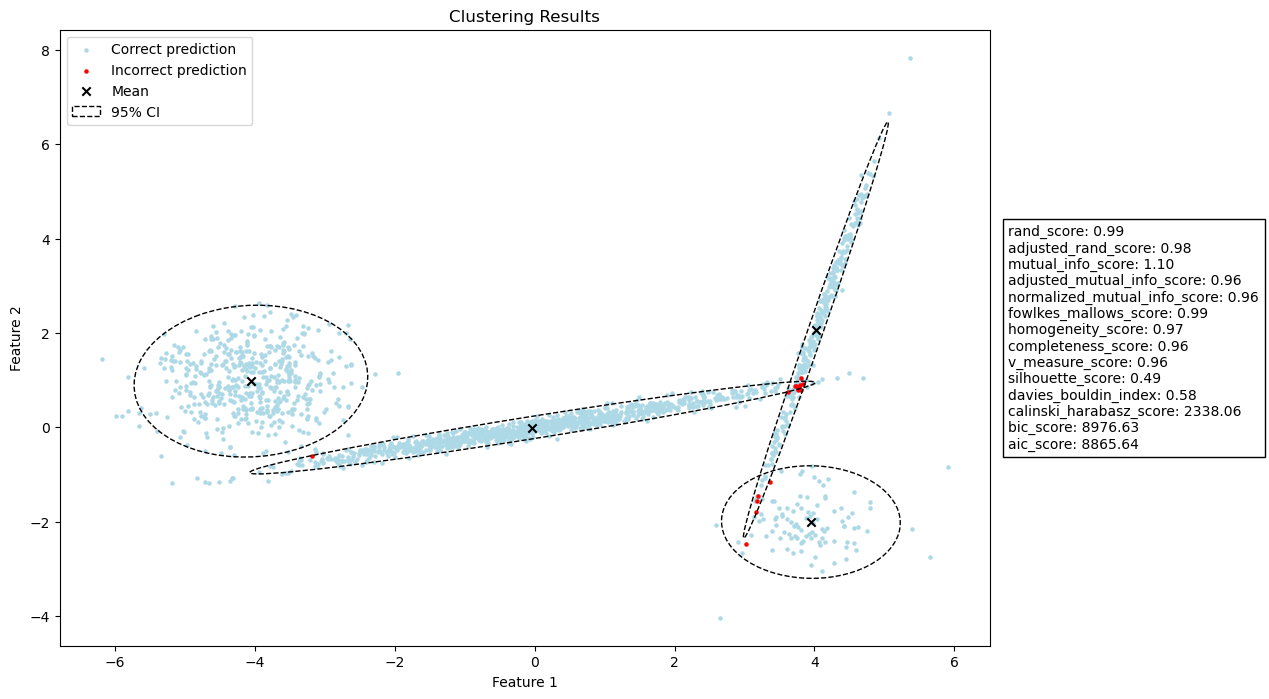

In [9]:
# Plot the clustering results
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_clustering(X_tensor, y_tensor, y_pred, gmm.means_, gmm.covariances_, ax, all_scores)

# print dataframe of all_scores
df = pd.DataFrame(all_scores.items(), columns=['Metric', 'Value'])
df
